### **Lets Grow more**
### **Data Science Internship(JAN-2023)**
### [Task: Stock Market Prediction And Forecasting Using Stacked LSTM](https://www.canva.com/design/DAEjrwWV35w/-gxHUkJMO1Zr4pYVVpOYcg/view?utm_content=DAEjrwWV35w&utm_campaign=designshare&utm_medium=link&utm_source=sharebutton#1)
### **Aman Gupta**

In [1]:
#Importing the libraries
import pandas_datareader as pdr
import numpy as np
import pandas as pd

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

#For creating LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Reading the dataset
# df = pdr.get_data_tiingo("AAPL",api_key=key)
df = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv")

In [3]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


In [5]:
df1 = df.reset_index()['Close']

In [6]:
df1

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

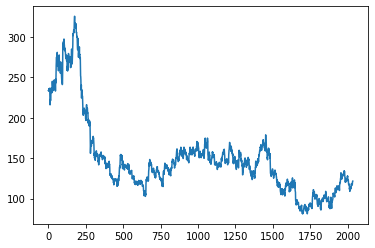

In [7]:
plt.plot(df1)

### **Observation :- It is non stationary**

### **Test for stationary**

* Since we are using LSTM model no need of stationary data.
* If timeseries is done by arima model then need to make the data stationary, as here p value is less than 0.05 so reject the null hypothesis

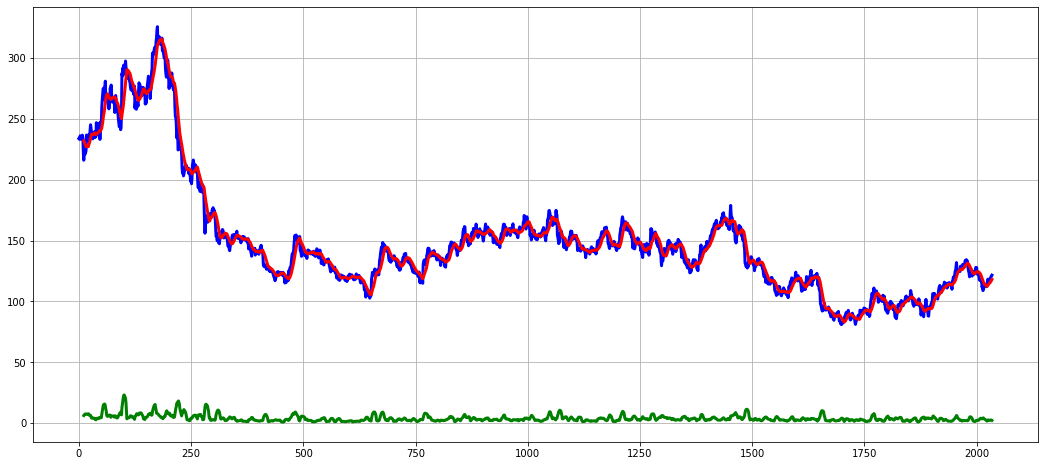

Test Statistics             -1.738101
p-value                      0.411596
No of lags                  16.000000
No of observation used    2018.000000
critical value (1%)         -3.433595
critical value (5%)         -2.862973
critical value (10%)        -2.567533
dtype: float64


In [8]:
def stationary_test(time_series):
    try:
        rolling_mean = time_series.rolling(12).mean()
        rolling_std = time_series.rolling(12).std()

        plt.figure(figsize=(18,8))
        plt.grid('both')
        plt.plot(time_series, color='blue', label='Orginal', linewidth=3)
        plt.plot(rolling_mean, color='red', label='Rolling Mean', linewidth=3)
        plt.plot(rolling_std, color='green', label='Rolling Std', linewidth=3)
        plt.show()
        
        adft = adfuller(time_series, autolag='AIC')
        output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No of lags', 'No of observation used'])
        
        for key, values in adft[4].items():
            output['critical value (%s)'%key]=values
        
        print(output)
    
    except Exception as e:
        print(e)
stationary_test(df1) 

In [9]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
print(df1)

[[0.62418301]
 [0.62214052]
 [0.62622549]
 ...
 [0.1621732 ]
 [0.16319444]
 [0.16584967]]


### In time series order matters alot so we arrange data according to time while splitting into train and test
Eg:-
price :- 120, 130, 125, 140, 134, 150, |||| 160, 190, 154

trainging----> 120, 130, 125, 140, 134, 150

testing---->160, 190, 154

In [11]:
##splitting dataset into train and test split

training_size = int(len(df1) * 0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0 : training_size, : ], df1[training_size : len(df1), : 1]

In [12]:
training_size, test_size

(1322, 713)

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i+time_step), 0]   ### i = 0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
X_train.shape, y_train.shape

((1221, 100), (1221,))

In [16]:
X_test.shape, ytest.shape

((612, 100), (612,))

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [18]:
#Stacked LSTM with 3 sequential data and then dense
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
#return_sequences=it will output all the hidden states of each time steps.
model.add(LSTM(50, return_sequences=True))
#50 is nothing but neurons we are passing
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train, y_train, validation_data=(X_test,ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 11s 75ms/step - loss: 0.0301 - val_loss: 0.0048
Epoch 2/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0028 - val_loss: 9.0638e-04
Epoch 3/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 5/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 9.3037e-04
Epoch 8/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0014 - val_los

In [21]:
### Lets Do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

20/20 [==============================] - 0s 6ms/step


In [22]:
##Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [23]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

167.72794493042684

In [24]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

117.19711334338442

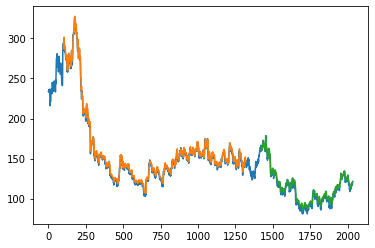

In [25]:

### Plotting 
# shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back, : ] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1 : len(df1) - 1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
len(test_data)

713

In [26]:
x_input = test_data[613 : ].reshape(1,-1)
x_input.shape

(1, 100)

In [27]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [28]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1 : ]
        
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1
    

print(lst_output)

[0.17145374]
101
1 day input [0.13848039 0.14011438 0.13888889 0.13541667 0.14011438 0.1380719
 0.13071895 0.13071895 0.12867647 0.11846405 0.14644608 0.14808007
 0.15910948 0.15992647 0.15788399 0.16441993 0.17892157 0.17933007
 0.19260621 0.20812908 0.18974673 0.18055556 0.18239379 0.17708333
 0.17810458 0.18055556 0.17810458 0.17851307 0.19607843 0.18913399
 0.18954248 0.19403595 0.19444444 0.20200163 0.19771242 0.19934641
 0.19873366 0.1997549  0.2128268  0.21568627 0.20445261 0.21772876
 0.21098856 0.21425654 0.19750817 0.18811275 0.17851307 0.17381536
 0.16033497 0.16564542 0.17116013 0.17422386 0.18035131 0.17401961
 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065 0.17279412
 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222 0.17238562
 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268
 0.15196078 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745
 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967
 0.12806373 0.13031046 0.12724673 0

In [29]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [30]:
len(df1)

2035

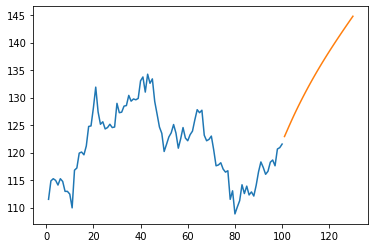

In [33]:
plt.plot(day_new,scaler.inverse_transform(df1[1935:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

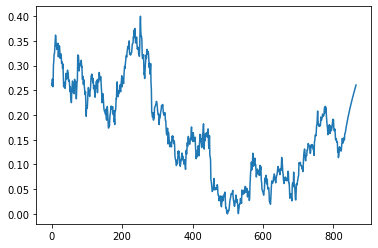

In [34]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [35]:
df3=scaler.inverse_transform(df3).tolist()

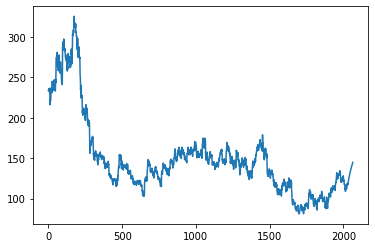

In [36]:
plt.plot(df3)